# Tensorflow Discrete Optimizer Implementation

Following a phone call with Koen, he recommended I take another look at the [quantizers.py](https://github.com/larq/larq/blob/main/larq/quantizers.py) file within `Larq`. This contains useful examples of using `tf.custom_gradient` decorators to create discrete gradients that realise the discrete optimizer in Tensorflow.

First, we begin by defining the activation and its gradient.

In [50]:
from re import X
import tensorflow as tf
import numpy as np

# Batch_size 1 implementation to agree with theory
@tf.custom_gradient
def linear(W,x,b):
  """Assumption here is that we do XOR accumulate,
  although we get similar results we assume XNOR"""
  bx = tf.broadcast_to(tf.transpose(x),W.shape)
  e = ((1-bx) * W) + (bx * (1-W))

  def grad(dy):
    return dy * ((dy-1)//2 + e),\
           tf.cast(tf.math.reduce_sum(dy * ((dy-1)//2 + e),1) < e.shape[1]/2,tf.float32),\
           dy

  return tf.cast(tf.math.reduce_sum(e,0) < b, tf.float32), grad

# Arbitrary batch_size to agree with GPU reality
@tf.custom_gradient
def linear_batch(W,X,b):
  """Same as above except working on the assumption of batched data"""
  batch_size = X.shape[0]
  input_dims = X.shape[1]
  output_dims = W.shape[1]

  print(X,W)

  bX = tf.broadcast_to(X,(output_dims,batch_size,input_dims))
  bX = tf.transpose(bX,[1,2,0])
  bW = tf.broadcast_to(W,(batch_size,input_dims,output_dims))

  e = ((1-bX) * bW) + (bX * (1 - bW))

  def grad(dy):
    return tf.math.reduce_sum(dy * ((dy-1)//2 + e),0),\
            tf.cast(tf.math.reduce_sum(dy * ((dy-1)//2 + e),2) < e.shape[2]/2,tf.float32),\
            dy

  return tf.cast(tf.math.reduce_sum(e,1),tf.float32)

# False Positive: was it active when it shouldn't have been
# False Negative: was it inactive when it shouldn't have been
@tf.custom_gradient
def loss(yhat,y):
  e = (yhat * (1-y)) - ((1-yhat) * y)
  def grad(dy):
    dz_dyhat = e
    dz_dy = e
    return dy * dz_dyhat, dy * dz_dy

  return e, grad

# One hot encode label m out of n choices
def one_hot(n,m):
  out = np.zeros((1,n))
  out[0,m] = 1
  return tf.convert_to_tensor(out,tf.float32)

Next we load and format MNIST for use in Tensorflow and train our 1 layer test model on it.



In [51]:
from tqdm import tqdm
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical

# Initial Data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = tf.reshape(tf.cast(x_train > 50, tf.float32),(60000,784))
y_train = tf.convert_to_tensor(to_categorical(y_train))

# Initial model parameters
W = tf.cast(tf.random.uniform((28*28,10)) > 0.5,tf.float32)
b = tf.zeros((1,10)) + 28*28/2
weight_counters = np.zeros(W.shape)
bias_counters = np.zeros(b.shape)

# Important hyperparamaters
WEIGHT_THRESHOLD = 4
BIAS_THRESHOLD = 4
BATCH_SIZE = 16

# Flip weights using counter/inertia/confidence information
def flip_weights(counters, weights):
  out1 = tf.where(counters > WEIGHT_THRESHOLD, 1-weights, weights)
  out2 = tf.where(counters > WEIGHT_THRESHOLD, 0, counters)
  return out1, out2

# Increment/decrement biases with counter/interia/confidence information
def indecr_biases(counters, biases):
  out1 = tf.where(counters > BIAS_THRESHOLD, biases - tf.math.sign(counters), biases)
  out2 = tf.where(counters > BIAS_THRESHOLD, 0, counters)
  return out1, out2

# Take step of size 1 towards 0 for all elements in a counter tensor
def decr_counter(counter):
  return tf.math.sign(counter) * (tf.math.sign(counter) * counter - 1)

losses = []
loss_cache = 0

for i in tqdm(range(0, 60000, BATCH_SIZE)):

  # 1 batch feed forward step
  with tf.GradientTape(persistent = True) as tape:
    X = x_train[i:i+BATCH_SIZE]
    Y = y_train[i:i+BATCH_SIZE]
    tape.watch([X,W,b,Y])
    Yhat = linear_batch(W,X,b)
    truth = loss(Yhat, Y)

  # Compute and cache losses
  loss_cache += tf.math.reduce_sum(abs(truth))

  # Increment counters using gradient data
  weight_counters += tape.gradient(truth,W)
  bias_counters += tape.gradient(truth,b)

  # Adjust weights and biases accordingly
  W, weight_counters = flip_weights(weight_counters, W)
  b, bias_counters = indecr_biases(bias_counters, b)

  # Decrement counters
  weight_counters = decr_counter(weight_counters)
  bias_counters = decr_counter(bias_counters)

  # Keep track of loss data
  if i % (BATCH_SIZE * (1000 // BATCH_SIZE)) == 0:
    losses.append(loss_cache/(BATCH_SIZE * (1000 // BATCH_SIZE)))
    loss_cache = 0

# Plot losses
plt.plot(losses[1:])

  0%|          | 0/3750 [00:00<?, ?it/s]

tf.Tensor(
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]], shape=(16, 784), dtype=float32) tf.Tensor(
[[0. 1. 0. ... 0. 1. 0.]
 [0. 0. 1. ... 0. 0. 1.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [1. 1. 1. ... 0. 1. 1.]
 [1. 0. 0. ... 0. 0. 1.]
 [1. 1. 1. ... 0. 0. 0.]], shape=(784, 10), dtype=float32)


ValueError: ignored

In [20]:
# Are my biases training sensibly?
print(b)

tf.Tensor([[162. 112. 142. 140. 136. 118. 141. 123. 119. 127.]], shape=(1, 10), dtype=float32)


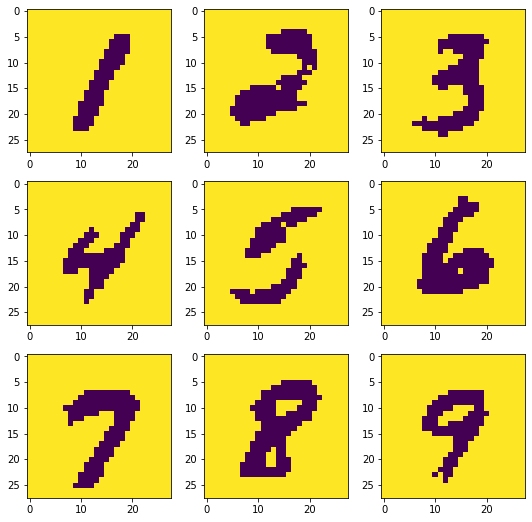

In [21]:
fig, axs = plt.subplots(3,3,figsize=(9,9))

# Do the weights look like a statistical representation of MNIST classes?
for i in range(9):
  axs[i//3][i%3].imshow(tf.reshape(W[:,i+1],(28,28)))

In [27]:
x_test = tf.reshape(tf.cast(x_test > 50, tf.float32),(10000,1,784))
y_test = tf.convert_to_tensor(to_categorical(y_test))

tf.reduce_sum(tf.cast((x_test @ W) < b, tf.float32) == y_test)/10000

<tf.Tensor: shape=(10000, 1, 10), dtype=float32, numpy=
array([[[0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)>

In [22]:
layer0_neurons = 28*28
layer1_neurons = 1024
layer2_neurons = 1024
layer3_neurons = 1024
layer4_neurons = 1024
layer5_neurons = 1024
layer6_neurons = 1024
layer7_neurons = 1024
layer8_neurons = 1024
layer9_neurons = 1024
layer10_neurons = 10

W1 = tf.cast(tf.random.uniform((layer0_neurons,layer1_neurons)) > 0.5,tf.float32)
W2 = tf.cast(tf.random.uniform((layer1_neurons,layer2_neurons)) > 0.5,tf.float32)
W3 = tf.cast(tf.random.uniform((layer2_neurons,layer3_neurons)) > 0.5,tf.float32)
W4 = tf.cast(tf.random.uniform((layer3_neurons,layer4_neurons)) > 0.5,tf.float32)
W5 = tf.cast(tf.random.uniform((layer4_neurons,layer5_neurons)) > 0.5,tf.float32)
W6 = tf.cast(tf.random.uniform((layer5_neurons,layer6_neurons)) > 0.5,tf.float32)
W7 = tf.cast(tf.random.uniform((layer6_neurons,layer7_neurons)) > 0.5,tf.float32)
W8 = tf.cast(tf.random.uniform((layer7_neurons,layer8_neurons)) > 0.5,tf.float32)
W9 = tf.cast(tf.random.uniform((layer8_neurons,layer9_neurons)) > 0.5,tf.float32)
W10 = tf.cast(tf.random.uniform((layer9_neurons,layer10_neurons)) > 0.5,tf.float32)

b1 = tf.zeros((1,layer1_neurons)) + layer1_neurons / 2
b2 = tf.zeros((1,layer2_neurons)) + layer2_neurons / 2
b3 = tf.zeros((1,layer3_neurons)) + layer3_neurons / 2
b4 = tf.zeros((1,layer4_neurons)) + layer4_neurons / 2
b5 = tf.zeros((1,layer5_neurons)) + layer5_neurons / 2
b6 = tf.zeros((1,layer6_neurons)) + layer6_neurons / 2
b7 = tf.zeros((1,layer7_neurons)) + layer7_neurons / 2
b8 = tf.zeros((1,layer8_neurons)) + layer8_neurons / 2
b9 = tf.zeros((1,layer9_neurons)) + layer9_neurons / 2
b10 = tf.zeros((1,layer10_neurons)) + layer10_neurons / 2

W1Cs = tf.zeros((layer0_neurons,layer1_neurons))
W2Cs = tf.zeros((layer1_neurons,layer2_neurons))
W3Cs = tf.zeros((layer2_neurons,layer3_neurons))
W4Cs = tf.zeros((layer3_neurons,layer4_neurons))
W5Cs = tf.zeros((layer4_neurons,layer5_neurons))
W6Cs = tf.zeros((layer5_neurons,layer6_neurons))
W7Cs = tf.zeros((layer6_neurons,layer7_neurons))
W8Cs = tf.zeros((layer7_neurons,layer8_neurons))
W9Cs = tf.zeros((layer8_neurons,layer9_neurons))
W10Cs = tf.zeros((layer9_neurons,layer10_neurons))

b1Cs = tf.zeros(layer1_neurons)
b2Cs = tf.zeros(layer2_neurons)
b3Cs = tf.zeros(layer3_neurons)
b4Cs = tf.zeros(layer4_neurons)
b5Cs = tf.zeros(layer5_neurons)
b6Cs = tf.zeros(layer6_neurons)
b7Cs = tf.zeros(layer7_neurons)
b8Cs = tf.zeros(layer8_neurons)
b9Cs = tf.zeros(layer9_neurons)
b10Cs = tf.zeros(layer10_neurons)

losses = []
loss_cache = 0

for i in tqdm(range(60000)):

  with tf.GradientTape(persistent = True) as tape:
    x = x_train[i]
    y = y_train[i]
    tape.watch([x,W1,W2,W3,W4,W5,W6,W7,W8,W9,W10,
                b1,b2,b3,b4,b5,b6,b7,b8,b9,b10,y])
    z1 = linear(W1,x,b1)
    z2 = linear(W2,z1,b2)
    z3 = linear(W3,z2,b3)
    z4 = linear(W4,z3,b4)
    z5 = linear(W5,z4,b5)
    z6 = linear(W6,z5,b6)
    z7 = linear(W7,z6,b7)
    z8 = linear(W8,z7,b8)
    z9 = linear(W9,z8,b9)
    yhat = linear(W10,z9,b10)

    truth = loss(yhat,y)

  loss_cache += tf.math.reduce_sum(abs(truth))

  W1Cs += tape.gradient(truth,W1)
  W2Cs += tape.gradient(truth,W2)
  W3Cs += tape.gradient(truth,W3)
  W4Cs += tape.gradient(truth,W4)
  W5Cs += tape.gradient(truth,W5)
  W6Cs += tape.gradient(truth,W6)
  W7Cs += tape.gradient(truth,W7)
  W8Cs += tape.gradient(truth,W8)
  W9Cs += tape.gradient(truth,W9)
  W10Cs += tape.gradient(truth,W10)

  b1Cs += tape.gradient(truth,b1)
  b2Cs += tape.gradient(truth,b2)
  b3Cs += tape.gradient(truth,b3)
  b4Cs += tape.gradient(truth,b4)
  b5Cs += tape.gradient(truth,b5)
  b6Cs += tape.gradient(truth,b6)
  b7Cs += tape.gradient(truth,b7)
  b8Cs += tape.gradient(truth,b8)
  b9Cs += tape.gradient(truth,b9)
  b10Cs += tape.gradient(truth,b10)

  W1, W1Cs = flip_weights(W1Cs, W1)
  W2, W2Cs = flip_weights(W2Cs, W2)
  W3, W3Cs = flip_weights(W3Cs, W3)
  W4, W4Cs = flip_weights(W4Cs, W4)
  W5, W5Cs = flip_weights(W5Cs, W5)
  W6, W6Cs = flip_weights(W6Cs, W6)
  W7, W7Cs = flip_weights(W7Cs, W7)
  W8, W8Cs = flip_weights(W8Cs, W8)
  W9, W9Cs = flip_weights(W9Cs, W9)
  W10, W10Cs = flip_weights(W10Cs, W10)

  b1, b1Cs = indecr_biases(b1Cs, b1)
  b2, b2Cs = indecr_biases(b2Cs, b2)
  b3, b3Cs = indecr_biases(b3Cs, b3)
  b4, b4Cs = indecr_biases(b4Cs, b4)
  b5, b5Cs = indecr_biases(b5Cs, b5)
  b6, b6Cs = indecr_biases(b6Cs, b6)
  b7, b7Cs = indecr_biases(b7Cs, b7)
  b8, b8Cs = indecr_biases(b8Cs, b8)
  b9, b9Cs = indecr_biases(b9Cs, b9)
  b10, b10Cs = indecr_biases(b10Cs, b10)

  if i % 16 == 0 :

    W1Cs = decr_counter(W1Cs)
    W2Cs = decr_counter(W2Cs)
    W3Cs = decr_counter(W3Cs)
    W4Cs = decr_counter(W4Cs)
    W5Cs = decr_counter(W5Cs)
    W6Cs = decr_counter(W6Cs)
    W7Cs = decr_counter(W7Cs)
    W8Cs = decr_counter(W8Cs)
    W9Cs = decr_counter(W9Cs)
    W10Cs = decr_counter(W10Cs)

    b1Cs = decr_counter(b1Cs)
    b2Cs = decr_counter(b2Cs)
    b3Cs = decr_counter(b3Cs)
    b4Cs = decr_counter(b4Cs)
    b5Cs = decr_counter(b5Cs)
    b6Cs = decr_counter(b6Cs)
    b7Cs = decr_counter(b7Cs)
    b8Cs = decr_counter(b8Cs)
    b9Cs = decr_counter(b9Cs)
    b10Cs = decr_counter(b10Cs)

  if i % 1000 == 0:

    losses.append(loss_cache/1000)
    loss_cache = 0

plt.plot(losses[1:])

 18%|█▊        | 10736/60000 [20:35<1:34:28,  8.69it/s]


KeyboardInterrupt: ignored